In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

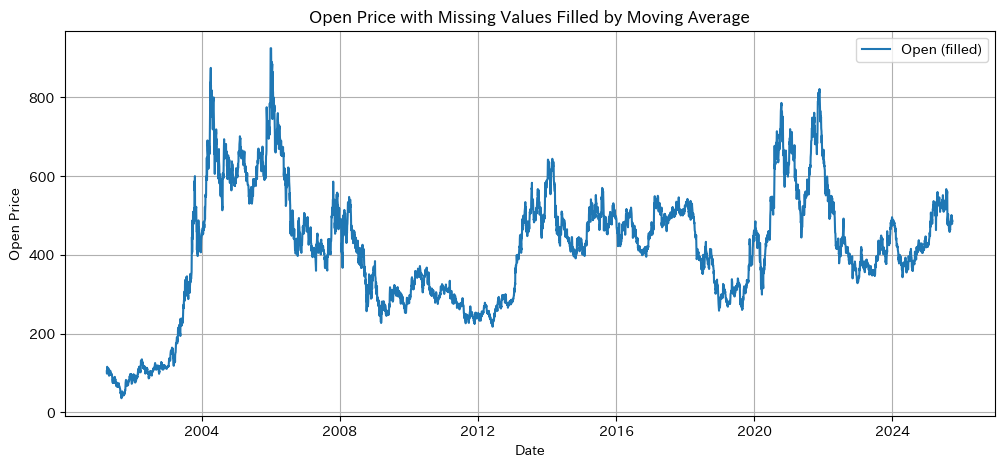

,open,high,low,close,volume,adj_close,split_factor_to_present,split_adj_open,split_adj_high,split_adj_low,split_adj_close,split_adj_volume
date,,,,,,,,,,,,
2001-04-02,103.906250,103.906250,100.585938,100.976562,8448000.0,100.98,51200.0,103.906250,103.906250,100.585938,100.976562,8448000.0
2001-04-03,99.023438,101.562500,98.242188,100.000000,9062400.0,100.00,51200.0,99.023438,101.562500,98.242188,100.000000,9062400.0
2001-04-04,98.046875,98.046875,95.703125,96.679688,19353600.0,96.68,51200.0,98.046875,98.046875,95.703125,96.679688,19353600.0
2001-04-05,105.468750,105.664062,100.585938,105.664062,11264000.0,105.66,51200.0,105.468750,105.664062,100.585938,105.664062,11264000.0
2001-04-06,115.429688,115.625000,110.351562,111.718750,23756800.0,111.72,51200.0,115.429688,115.625000,110.351562,111.718750,23756800.0
2001-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-09,107.421875,107.421875,100.976562,101.757812,6246400.0,101.76,51200.0,107.421875,107.421875,100.976562,101.757812,6246400.0
2001-04-10,102.539062,104.492188,100.976562,101.757812,4710400.0,101.76,51200.0,102.539062,104.492188,100.976562,101.757812,4710400.0


In [46]:
df = pd.read_csv("../data/stock_history_all.csv", header=0)
df["date"] = pd.to_datetime(df["date"]).dt.normalize()
# Use split-adjusted columns from crawler if available
if 'split_adj_open' in df.columns:
    df['open'] = df['split_adj_open']
    df['high'] = df['split_adj_high']
    df['low'] = df['split_adj_low']
    df['close'] = df['split_adj_close']
    if 'split_adj_volume' in df.columns:
        df['volume'] = df['split_adj_volume']

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["open"], label="Open (filled)")
plt.title("Open Price with Missing Values Filled by Moving Average")
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.legend()
plt.grid(True)
plt.show()

df = df.set_index("date").sort_index()
df = df[~df.index.duplicated(keep="last")]
df = df.asfreq("D")
df.head(15)

## 株式分割を考慮したデータ集計


In [47]:
# 株式分割の調整（クローラの分割調整列がある場合はそれを使用）
if 'split_adj_open' in df.columns:
    # 既に分割調整済みのため追加調整は不要
    pass
else:
    # 各日付の係数 = その日付より後に起きる分割比の積
    def _factor_for(d):
        f = 1.0
        for ev_date, r in events:
            if ev_date > d:
                f *= r
        return f
    factors = df.index.to_series().apply(_factor_for)
    for c in ['open','high','low','close']:
        if c in df.columns:
            df[c] = df[c] / factors.values
    if 'volume' in df.columns:
        df['volume'] = (df['volume'].astype('float64') * factors.values)


In [48]:
ma_win = 5  # 窓幅（例：5営業日相当）
# 数値列のみ対象
num_cols = df.select_dtypes("number").columns

# 前後を使った移動平均（NaN は自動的に除外される）
ma = df[num_cols].rolling(window=ma_win, min_periods=1, center=True).mean()

# 欠損がある場所だけ移動平均で埋める
filled = df.copy()
filled[num_cols] = df[num_cols].where(df[num_cols].notna(), ma)

# 端のほうでまだ残る NaN を念のため片側で埋める（任意）
filled[num_cols] = filled[num_cols].ffill().bfill()

# 例）確認
filled.head(10)

,open,high,low,close,volume,adj_close,split_factor_to_present,split_adj_open,split_adj_high,split_adj_low,split_adj_close,split_adj_volume
date,,,,,,,,,,,,
2001-04-02,103.906250,103.906250,100.585938,100.976562,8.448000e+06,100.98,51200.0,103.906250,103.906250,100.585938,100.976562,8.448000e+06
2001-04-03,99.023438,101.562500,98.242188,100.000000,9.062400e+06,100.00,51200.0,99.023438,101.562500,98.242188,100.000000,9.062400e+06
2001-04-04,98.046875,98.046875,95.703125,96.679688,1.935360e+07,96.68,51200.0,98.046875,98.046875,95.703125,96.679688,1.935360e+07
2001-04-05,105.468750,105.664062,100.585938,105.664062,1.126400e+07,105.66,51200.0,105.468750,105.664062,100.585938,105.664062,1.126400e+07
2001-04-06,115.429688,115.625000,110.351562,111.718750,2.375680e+07,111.72,51200.0,115.429688,115.625000,110.351562,111.718750,2.375680e+07
2001-04-07,109.440104,109.570312,103.971354,106.380208,1.375573e+07,106.38,51200.0,109.440104,109.570312,103.971354,106.380208,1.375573e+07
2001-04-08,108.463542,109.179688,104.101562,105.078125,1.157120e+07,105.08,51200.0,108.463542,109.179688,104.101562,105.078125,1.157120e+07
2001-04-09,107.421875,107.421875,100.976562,101.757812,6.246400e+06,101.76,51200.0,107.421875,107.421875,100.976562,101.757812,6.246400e+06
2001-04-10,102.539062,104.492188,100.976562,101.757812,4.710400e+06,101.76,51200.0,102.539062,104.492188,100.976562,101.757812,4.710400e+06


In [49]:
filled.tail()

,open,high,low,close,volume,adj_close,split_factor_to_present,split_adj_open,split_adj_high,split_adj_low,split_adj_close,split_adj_volume
date,,,,,,,,,,,,
2025-09-22,493.900000,496.300000,485.800000,486.500000,1.463750e+07,486.500000,1.0,493.900000,496.300000,485.800000,486.500000,1.463750e+07
2025-09-23,487.133333,490.266667,479.933333,486.033333,1.681323e+07,486.033333,1.0,487.133333,490.266667,479.933333,486.033333,1.681323e+07
2025-09-24,478.500000,485.500000,472.300000,485.500000,2.225270e+07,485.500000,1.0,478.500000,485.500000,472.300000,485.500000,2.225270e+07
2025-09-25,489.000000,489.000000,481.700000,486.100000,1.354950e+07,486.100000,1.0,489.000000,489.000000,481.700000,486.100000,1.354950e+07
2025-09-26,486.100000,488.700000,483.000000,485.400000,1.094650e+07,485.400000,1.0,486.100000,488.700000,483.000000,485.400000,1.094650e+07


In [50]:
print(filled.columns)
print(filled[["open", "volume"]].head())

Index(['open', 'high', 'low', 'close', 'volume', 'adj_close',
       'split_factor_to_present', 'split_adj_open', 'split_adj_high',
       'split_adj_low', 'split_adj_close', 'split_adj_volume'],
      dtype='object')
                  open      volume
date                              
2001-04-02  103.906250   8448000.0
2001-04-03   99.023438   9062400.0
2001-04-04   98.046875  19353600.0
2001-04-05  105.468750  11264000.0
2001-04-06  115.429688  23756800.0


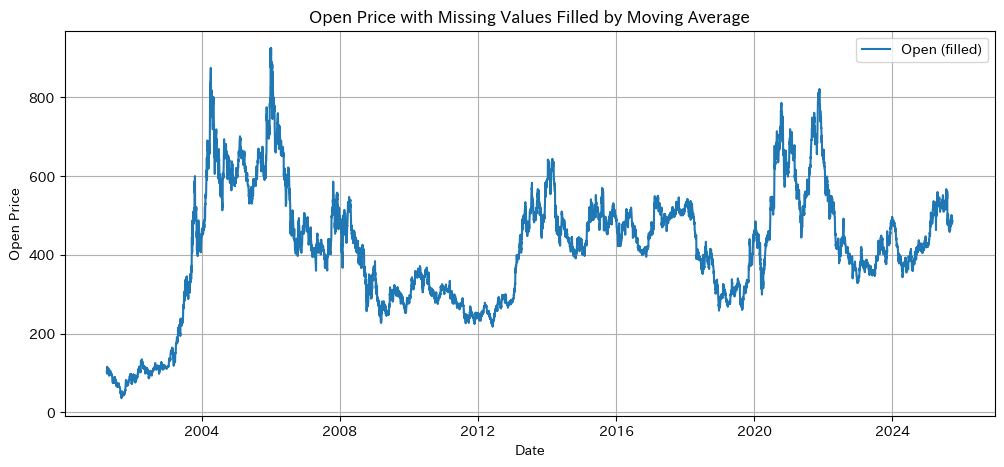

In [60]:
plt.figure(figsize=(12,5))
plt.plot(filled.index, filled["open"], label="Open (filled)")
plt.title("Open Price with Missing Values Filled by Moving Average")
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.legend()
plt.grid(True)
plt.savefig("../output/output_OpenPriceWithMissingValuesFilledByMovingAverage.png")
plt.show()

In [52]:
print("date range:", filled.index.min(), "→", filled.index.max())
print(filled[["open","high","low","close","volume"]].describe())

date range: 2001-04-02 00:00:00 → 2025-09-26 00:00:00
              open         high          low        close        volume
count  8944.000000  8944.000000  8944.000000  8944.000000  8.944000e+03
mean    416.714480   422.431870   410.737077   416.435848  1.600607e+07
std     156.052461   158.328544   153.524164   155.832958  1.097539e+07
min      35.546875    39.062500    35.546875    39.062500  9.984000e+05
25%     310.000000   314.000000   305.000000   309.000000  9.531525e+06
50%     423.000000   428.666667   417.333333   422.500000  1.341257e+07
75%     511.333333   518.000000   505.000000   511.041667  1.909995e+07
max     925.000000   950.000000   890.000000   905.000000  1.798291e+08
